In [1]:
%load_ext autoreload
%autoreload

In [96]:
import duckdb

from sknetwork.data import convert_edge_list
from sknetwork.visualization import svg_graph
from IPython.display import SVG
import numpy as np
from sknetwork.ranking import PageRank

from SRP.SRP_files import Vector_file
from compare_tools.configuration import config, init_htid_args, my_resolver
from scipy.spatial.distance import cdist

In [99]:
config.update(config['full'])
vecf = Vector_file(config['glove_data_path'], mode='r', offset_cache=True)

In [3]:
con = duckdb.connect('/data/saddl/full.duckdb', read_only=True, config={'max_memory':'16G', 'threads':4})
con.execute("CREATE INDEX htid_idx ON meta (htid);")
con.execute("CREATE INDEX target_clean_idx ON clean_predictions (target);")

In [85]:
# get all unique works and manifestations
works = con.execute('''SELECT work_id FROM work_stats WHERE gov_prop < .5 AND serial_prop <.5 AND label_count > 1''').fetch_df().work_id
manifestations = con.execute('''
SELECT man_id FROM work_stats
JOIN clusters on work_stats.work_id == clusters.work_id
WHERE gov_prop < .5 AND serial_prop <.5 AND label_count > 1''').fetch_df().man_id
manifestations

0         2035
1        59499
2        70758
3        51218
4        59786
         ...  
56771    47210
56772    83210
56773    87881
56774    71080
56775    19255
Name: work_id, Length: 56776, dtype: int64

In [221]:
work_id = 3118

def get_best_volumes(work_id=None, man_id=None, include_pagerank=True, include_vecs=True):
    assert work_id or man_id
    assert not (work_id and man_id)
    assert include_pagerank or include_vecs
    
    if work_id:
        frame = 'work'
        label = work_id
    elif man_id:
        frame = 'man'
        label = man_id
        
    cols_to_process = []
    # Return details for works/manifestations in the clusters
    cluster_details = con.execute(f'''
    SELECT title, access, clusters.* FROM clusters
    JOIN meta on meta.htid == clusters.htid
    WHERE clusters.{frame}_id == {label}''').fetch_df()
    
    if include_pagerank:
        # Get edges and make a graph
        edge_df = con.execute(f'''
        SELECT target, candidate, clusters.{frame}_id, (swsm + swde) AS sw FROM clean_predictions
        JOIN clusters ON clean_predictions.target == clusters.htid
        JOIN clusters AS clusters2 ON clean_predictions.candidate == clusters2.htid
        WHERE clusters.{frame}_id == {label} AND clusters2.{frame}_id == clusters.{frame}_id
        ''').fetch_df()
        edge_list = list(edge_df[['target', 'candidate', 'sw']].itertuples(index=False))
        graph = convert_edge_list(edge_list)

        # Use Pagerank to score nodes
        pagerank = PageRank()
        scores = pagerank.fit_transform(graph.adjacency)
        score_ref = dict(zip(graph.names, scores))

        cluster_details['pr_scores'] = cluster_details['htid'].apply(lambda x: score_ref[x])
        cols_to_process.append(('best_network', 'pr_scores'))

    if include_vecs:
        # Use vector approach
        def get_book_vec(htid):
            try:
                _, vecs = list(zip(*vecf.find_prefix(htid)))
                return np.mean(vecs, axis=0)
            except:
                return pd.NA

        cluster_details['vec'] = cluster_details.htid.apply(get_book_vec)
        cluster_details = cluster_details[~cluster_details.vec.isna()]

        m = np.vstack(cluster_details.vec.values)
        centroid = np.sum(m, axis=0)
        median = np.median(m, axis=0)
        cluster_details['cent_dist'] = cdist([centroid], m, metric='cosine')[0]
        cluster_details['med_dist'] = cdist([median], m, metric='cosine')[0]
        cols_to_process += [('best_centroid', 'cent_dist'), ('best_median', 'med_dist')]

    fullview = cluster_details.access == "allow"
    best = {f"{frame}_id": label}
    
    for name, col in cols_to_process:
        df = cluster_details.sort_values(col, ascending=False)
        best[name] = df.iloc[0]['htid']
        if np.any(fullview):
            best[name+'_pd'] = df.query('access == "allow"').iloc[0]['htid']
        else:
            best[name+'_pd'] = pd.NA
    return best

get_best_volumes(work_id=work_id, include_pagerank=True, include_vecs=True)

{'work_id': 3118,
 'best_network': 'uc1.b3567393',
 'best_network_pd': 'uc1.b3567393',
 'best_centroid': 'mdp.39076001767172',
 'best_centroid_pd': 'nyp.33433075785323',
 'best_median': 'osu.32435014307193',
 'best_median_pd': 'osu.32435014307193'}

In [133]:
%%time
import time
start = time.time()
all_best = []
for i, work_id in enumerate(works[:100]):
    if i % 5 == 1:
        progress = i/len(works)
        elapsed = (time.time()-start)/60
        eta = elapsed/i*(len(works)-i)/60
        print(i, '{:.2f}m; {:.2f}% complete;{:.2f}hrs remaining'.format(elapsed, progress, eta))
    try:
        best = get_best_volumes(work_id=work_id, include_pagerank=False, include_vecs=True)
    except KeyboardInterrupt:
        raise
    except:
        print("Issue with work:", work_id)
        continue
    all_best.append(best)

all_best = pd.DataFrame(all_best)
all_best

1 0.01m; 0.00% complete;10.77hrs remaining
6 0.07m; 0.00% complete;10.85hrs remaining
11 0.13m; 0.00% complete;10.90hrs remaining
16 0.18m; 0.00% complete;10.58hrs remaining
21 0.23m; 0.00% complete;10.51hrs remaining
26 0.29m; 0.00% complete;10.50hrs remaining
31 0.34m; 0.00% complete;10.34hrs remaining
36 0.39m; 0.00% complete;10.31hrs remaining
41 0.44m; 0.00% complete;10.21hrs remaining
46 0.49m; 0.00% complete;10.15hrs remaining
51 0.55m; 0.00% complete;10.17hrs remaining
56 0.60m; 0.00% complete;10.10hrs remaining
61 0.65m; 0.00% complete;10.06hrs remaining
66 0.70m; 0.00% complete;10.03hrs remaining
71 0.75m; 0.00% complete;10.05hrs remaining
76 0.81m; 0.00% complete;10.02hrs remaining
81 0.86m; 0.00% complete;9.98hrs remaining
86 0.91m; 0.00% complete;9.97hrs remaining
91 0.96m; 0.00% complete;9.97hrs remaining
96 1.01m; 0.00% complete;9.93hrs remaining
CPU times: user 1min 3s, sys: 1.28 s, total: 1min 4s
Wall time: 1min 3s


,work_id,best_centroid,best_centroid_pd,best_median,best_median_pd
0,2035,uc1.b3512332,<NA>,uc1.b3512332,<NA>
1,59499,coo.31924079980151,mdp.39015036891433,coo.31924079980151,mdp.39015036891433
2,70758,coo.31924080030657,coo.31924080030657,coo.31924080030657,coo.31924080030657
3,51218,inu.30000116104138,<NA>,inu.30000116104138,<NA>
4,59786,mdp.39015064746848,<NA>,mdp.39015064746848,<NA>
...,...,...,...,...,...
95,9871,uc1.$b275438,uc1.$b275438,uc1.$b275438,uc1.$b275438
96,23660,mdp.39015003457994,mdp.39015003457994,mdp.39015003457994,mdp.39015003457994
97,19909,mdp.39015062935328,mdp.39015062935328,mdp.39015062935328,mdp.39015062935328
98,9941,coo1.ark:/13960/t2g73zp56,coo1.ark:/13960/t2g73zp56,coo1.ark:/13960/t2g73zp56,coo1.ark:/13960/t2g73zp56


In [136]:
all_cluster_members = con.execute(f'''
SELECT access, clusters.* FROM clusters
JOIN meta on meta.htid == clusters.htid
JOIN work_stats ON work_stats.work_id == clusters.work_id
WHERE gov_prop < .5 AND serial_prop <.5 AND label_count > 1''').fetch_df()

In [149]:
label = '21284'
cluster_details = all_cluster_members.query(f'man_id == {label}').copy()




cluster_details['vec'] = cluster_details.htid.apply(get_book_vec)
cluster_details = cluster_details[~cluster_details.vec.isna()]

m = np.vstack(cluster_details.vec.values)
centroid = np.sum(m, axis=0)
median = np.median(m, axis=0)
cluster_details['cent_dist'] = cdist([centroid], m, metric='cosine')[0]
cluster_details['med_dist'] = cdist([median], m, metric='cosine')[0]
cols_to_process = [('best_centroid', 'cent_dist'), ('best_median', 'med_dist')]

fullview = cluster_details.access == "allow"
best = {f"work_id": label}

for name, col in cols_to_process:
    df = cluster_details.sort_values(col, ascending=False)
    best[name] = df.iloc[0]['htid']
    if np.any(fullview):
        best[name+'_pd'] = df.query('access == "allow"').iloc[0]['htid']
    else:
        best[name+'_pd'] = pd.NA
pd.Series(best)

work_id                  21284
best_centroid       hvd.ah43rr
best_centroid_pd    hvd.ah43rr
best_median         hvd.ah43rr
best_median_pd      hvd.ah43rr
dtype: object

*time estimate after 100 works*

- 31hrs with both
- 31hrs with only pagerank (no improvement?!)
- 9hrs with only vecs

In [187]:
len(all_cluster_members.work_id.unique())

56776

## Faster alternative (for vecfile method)

This reduces individual DB calls for each work and uses Pandas groupby.

In [183]:
def best_copy(cluster_details):
    cluster_details = cluster_details.copy() # probably slow...
    
    # Use vector approach
    def get_book_vec(htid):
        try:
            _, vecs = list(zip(*vecf.find_prefix(htid)))
            return np.mean(vecs, axis=0)
        except:
            return pd.NA
    
    cluster_details['vec'] = cluster_details.htid.apply(get_book_vec)
    cluster_details = cluster_details[~cluster_details.vec.isna()]

    m = np.vstack(cluster_details.vec.values)
    centroid = np.sum(m, axis=0)
    median = np.median(m, axis=0)
    cluster_details['cent_dist'] = cdist([centroid], m, metric='cosine')[0]
    cluster_details['med_dist'] = cdist([median], m, metric='cosine')[0]
    cols_to_process = [('best_centroid', 'cent_dist'), ('best_median', 'med_dist')]

    fullview = cluster_details.access == "allow"
    best = {}

    for name, col in cols_to_process:
        df = cluster_details.sort_values(col, ascending=False)
        best[name] = df.iloc[0]['htid']
        if np.any(fullview):
            best[name+'_pd'] = df.query('access == "allow"').iloc[0]['htid']
        else:
            best[name+'_pd'] = pd.NA
    
    return  pd.Series(best)
best_copies = all_cluster_members.sort_values('work_id').iloc[9000:].groupby('work_id').apply(best_copy)

,best_centroid,best_centroid_pd,best_median,best_median_pd
work_id,,,,
771,hvd.32044080263155,hvd.32044080263155,nyp.33433075914279,nyp.33433075914279
772,mdp.39015002133166,<NA>,mdp.39015002133166,<NA>
775,mdp.39015063548534,mdp.39015063548534,mdp.39015063548534,mdp.39015063548534
776,hvd.32044102850344,hvd.32044102850344,hvd.32044102850344,hvd.32044102850344
777,nyp.33433082480926,nyp.33433082480926,nyp.33433082480926,nyp.33433082480926
779,uc1.b3453259,uc1.b3453259,uc1.b3453259,uc1.b3453259
780,mdp.39015065511332,<NA>,mdp.39015065511332,<NA>
781,uc1.$b100769,<NA>,uc1.$b100769,<NA>
783,uc1.$b243082,uc1.$b279797,uc1.$b243082,uc1.$b279797


In [224]:
%%time
# chunk, so that you can see some progress with the apply
collector = []
ranges = range(0, np.ceil(len(works2)/1000).astype(int))

for start in ranges:
    print(start, end=',')
    subrange = works[start*1000:start*1000+1000]
    collector.append(all_cluster_members[all_cluster_members.work_id.isin(subrange)].groupby('work_id').apply(best_copy))

pd.concat(collector).to_parquet('/data/saddl/best_work_copies-july23.parquet', compression='snappy')
pd.concat(collector).head()

,best_centroid,best_centroid_pd,best_median,best_median_pd
work_id,,,,
6,uc1.$b250921,uc1.$b250921,uc1.$b250921,uc1.$b250921
327,hvd.hn26nq,hvd.hn26nq,hvd.32044090314683,hvd.32044090314683
362,hvd.hl2m7t,hvd.hl2m7t,hvd.hl2m7t,hvd.hl2m7t
368,nyp.33433082151907,nyp.33433082151907,nyp.33433082151907,nyp.33433082151907
473,hvd.32044040633620,hvd.32044040633620,hvd.32044040633620,hvd.32044040633620


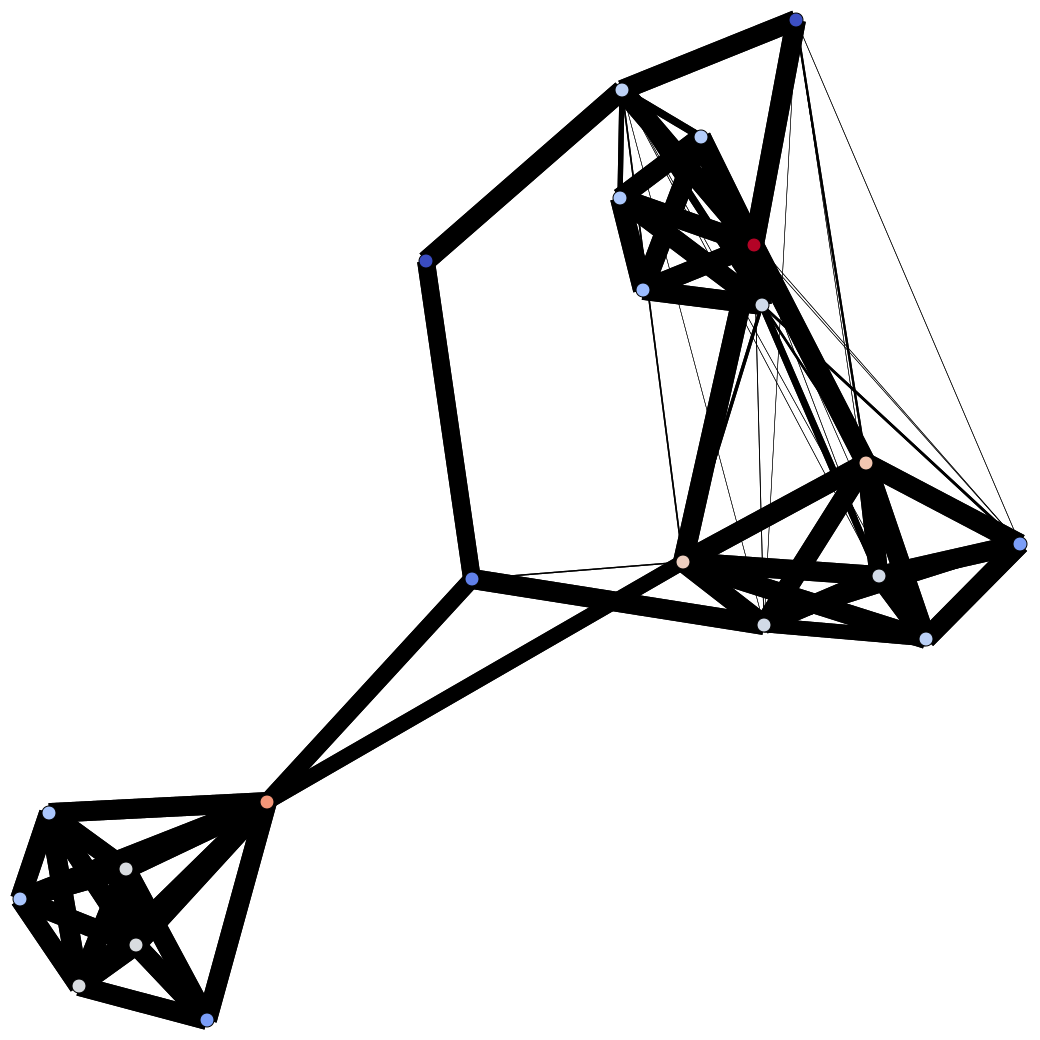

In [132]:
image = svg_graph(graph.adjacency, scores=scores, width=1000, height=1000)
SVG(image)